# 4) Target Model Training and Evaluation

In this notebook, we will make use of the features we have computed in the last notebook, define a target variable, and train a model for price changes prediction. We will do the following in order:

> A) Define list of features to be used. <br>
> B) Compute the target variable to be predicted. <br>
> C) Split data into training and testing dataset. <br>
> D) Upload training and testing data to S3 buckets. <br>
> E) Build the Neural Network model using SageMaker's PyTorch models. <br>
> E) Evaluate the model trained using training and testing dataset. 

First, import all the required data before any step mentioned above and set up SageMaker Resources


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
from data_reader import *
import seaborn as sns
from features_helper import FeaturesHelper
pd.options.display.max_columns = None
pd.options.display.max_rows = None

df = read_all_csvs()
helper = FeaturesHelper(df)

Reading in progress: [==================================================] 100.0%
Finished reading 366 csv files and 522051 entries found


In [3]:
import boto3
import sagemaker

In [4]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()

### A)  Define the list of features to be used

The final list of features to be used is defined below:

In [5]:
target_features_list = [
    '60m_chg_std', 
    '60m_z_price', 
    '60m_z_volume', 
    '60m_draw_up', 
    '60m_draw_down', 
    '5m_smoothed_volume_chg', 
    'log_volume', 
    'close_to_high', 
    'close_to_low', 
    'close_to_open', 
    'adx', 
    'macd', 
    'fso', 
]

We can check their correlation using the following codes:

In [6]:
helper.run_features_list(target_features_list, log=True)
df = helper.get_result(bool_dropna=True)

Computed 60m_chg_std               ; used 0.138s
Computed 60m_z_price               ; used 0.078s
Computed 60m_z_volume              ; used 0.078s
Computed 60m_draw_up               ; used 0.064s
Computed 60m_draw_down             ; used 0.071s
Computed 5m_smoothed_volume_chg    ; used 0.097s
Computed log_volume                ; used 0.07s
Computed close_to_high             ; used 0.055s
Computed close_to_low              ; used 0.058s
Computed close_to_open             ; used 0.062s
Computed adx                       ; used 14.246s
Computed macd                      ; used 0.403s
Computed fso                       ; used 0.442s
Finished 13 features computation


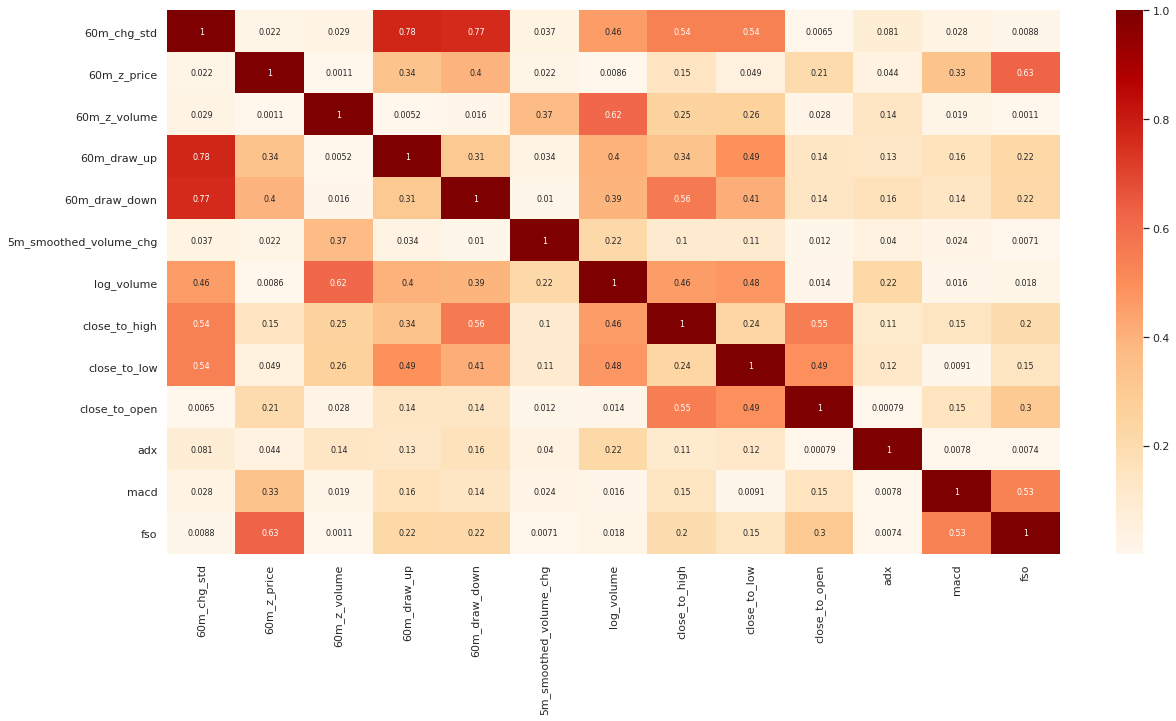

In [7]:
corr_df = df[target_features_list].corr().abs()
sns.set(rc={'figure.figsize':(20, 10)})
sns.heatmap(corr_df, annot=True, annot_kws={"fontsize": 8}, cmap='OrRd')

Although there still exist some higher-than-average correlations, we can see that most the dimension has been much reduced (25 $\rightarrow$ 13), which will make the NN training process much more efficient.

---

### B) Compute the target variable to be predicted

As we have mentioned before, we are trying to predict the 1-min forward price changes using the features computed. Let us build the required x-y matrix first.

To make the codes reusable, the function `preprocess_data` in `data_processing.py` is written for convenience. Soure code as follows:

In [8]:
!pygmentize data_processing.py

import pandas as pd
import os


def preprocess_data(input_df,           # result_df from FeaturesHelper.get_result(bool_dropna=True)
                    input_period=1):    # forward-looking period
    y_col = f'{input_period}m_fwd_chg'
    input_df.loc[:, y_col] = input_df['close'].pct_change(input_period).shift(-input_period) * 10000  # in bps
    feature_list = [i for i in input_df.columns if i not in ['date_time', 'open', 'high', 'low', 'close', 'volume', y_col]]
    res_df = input_df.loc[:, ['date_time', y_col] + feature_list].dropna().reset_index(drop=True)
    return res_df


def save_df(input_df, save_path):  # expect a df with columns ['y', 'x1', 'x2', 'x3' ...]
    if not os.path.exists(os.path.basename(save_path)):
        os.makedirs(os.path.basename(save_path))
    
    input_df.to_csv(save_path, index=False, header=False)
    print(f'Saved to {save_path}')
    return 


Also, since:
> Amazon SageMaker requires that a CSV file doesn't have a header record and that the target variable is in the first column.

We will keep `1m_fwd_chg` as the first column and drop `date_time` in the next step.

In [9]:
from data_processing import *

df = preprocess_data(df, input_period=1)
df.head()

,date_time,1m_fwd_chg,60m_chg_std,60m_z_price,60m_z_volume,60m_draw_up,60m_draw_down,5m_smoothed_volume_chg,log_volume,close_to_high,close_to_low,close_to_open,adx,macd,fso
0,2020-01-01 01:00:00,-4.077602,0.000704,-1.123762,-0.634879,13.749580,-21.451446,0.442304,1.998947,-3.244385,1.692353,-3.230525,35.520157,-0.552226,-33.500456
1,2020-01-01 01:01:00,-0.707628,0.000631,-1.679798,-0.097864,7.720485,-25.520301,0.033968,2.612076,-3.911234,3.567160,-3.911234,37.040723,-0.789266,-32.481254
2,2020-01-01 01:02:00,-1.609620,0.000630,-1.712799,-0.722088,7.012311,-26.226123,0.008016,1.942744,-1.845172,1.609879,-1.650975,38.071884,-0.921642,-35.957737
3,2020-01-01 01:03:00,-0.707792,0.000628,-1.856050,-0.406542,5.401562,-27.831522,0.043619,2.295279,-4.397476,0.000000,-1.137888,39.261958,-1.020602,-43.865031
4,2020-01-01 01:04:00,-1.054823,0.000620,-1.882046,-0.149173,4.693388,-28.537344,0.080779,2.491547,-1.720731,1.318703,-0.707792,40.955101,-1.049918,-43.219129


In the future, we can change the parameter `input_period` to construct other forward price changes for prediction and training.

---

### C) Split data into training and testing dataset

We will split the dataset into 60% training and 40% testing dataset respectively. One thing to note is that we can't not shuffle the dataset before splitting because this is a time-series data after all. In real-life application, we will train our model based on available data and try to predict the future data, which is unknown at current time. Therefore, we need a timestamp for a clear cut-off of training-testing dataset splitting.

In [10]:
# Splitting train and test dataset
ratio = 0.6
training_df = df.loc[df.index[:int(len(df) * ratio)], :].reset_index(drop=True)
testing_df = df.loc[df.index[int(len(df) * ratio):], :].reset_index(drop=True)
print(f'lenght of training_df = {len(training_df)}; date_time from {training_df.loc[0, "date_time"]} to {training_df.loc[training_df.index[-1], "date_time"]}')
print(f'lenght of testing_df  = {len(testing_df)}; date_time from {testing_df.loc[0, "date_time"]} to {testing_df.loc[testing_df.index[-1], "date_time"]}')

# Droping date_time for saving csv      
training_df.drop('date_time', axis=1, inplace=True)
testing_df.drop('date_time', axis=1, inplace=True)

lenght of training_df = 313194; date_time from 2020-01-01 01:00:00 to 2020-08-07 19:55:00
lenght of testing_df  = 208796; date_time from 2020-08-07 19:56:00 to 2020-12-31 23:58:00


In [11]:
training_df.head()

,1m_fwd_chg,60m_chg_std,60m_z_price,60m_z_volume,60m_draw_up,60m_draw_down,5m_smoothed_volume_chg,log_volume,close_to_high,close_to_low,close_to_open,adx,macd,fso
0,-4.077602,0.000704,-1.123762,-0.634879,13.749580,-21.451446,0.442304,1.998947,-3.244385,1.692353,-3.230525,35.520157,-0.552226,-33.500456
1,-0.707628,0.000631,-1.679798,-0.097864,7.720485,-25.520301,0.033968,2.612076,-3.911234,3.567160,-3.911234,37.040723,-0.789266,-32.481254
2,-1.609620,0.000630,-1.712799,-0.722088,7.012311,-26.226123,0.008016,1.942744,-1.845172,1.609879,-1.650975,38.071884,-0.921642,-35.957737
3,-0.707792,0.000628,-1.856050,-0.406542,5.401562,-27.831522,0.043619,2.295279,-4.397476,0.000000,-1.137888,39.261958,-1.020602,-43.865031
4,-1.054823,0.000620,-1.882046,-0.149173,4.693388,-28.537344,0.080779,2.491547,-1.720731,1.318703,-0.707792,40.955101,-1.049918,-43.219129


In [12]:
testing_df.head()

,1m_fwd_chg,60m_chg_std,60m_z_price,60m_z_volume,60m_draw_up,60m_draw_down,5m_smoothed_volume_chg,log_volume,close_to_high,close_to_low,close_to_open,adx,macd,fso
0,9.504975,0.000606,-1.327688,0.725545,52.414384,-45.106076,1.355969,4.689785,-6.851489,21.774182,21.534672,38.956185,-1.510104,26.106415
1,-4.790519,0.000620,-0.610872,0.197001,61.969178,-35.643974,1.344194,4.261480,-5.621231,9.513500,9.513500,37.483163,-0.069701,39.980109
2,7.287122,0.000621,-0.932321,0.058367,57.148973,-40.417418,1.337913,4.118140,-6.567714,1.983921,-4.790519,36.696379,0.532770,32.981104
3,10.038017,0.000619,-0.364644,0.656657,64.477740,-32.940031,1.127296,4.669310,-3.979595,7.406392,7.287122,35.044795,1.482818,43.622576
4,-0.934809,0.000633,0.454470,-0.163190,74.580479,-22.935080,-0.224477,3.842092,-0.467383,11.979889,10.038017,32.810832,2.804305,49.372576


---

### D) Upload training and testing data to S3 buckets

The function `save_df` defined in `data_processing` will help us save the train and test dataset to the desired directory (`processed_data` in our case). What we need to do will only be defining a prefix to specify where we will save our data in S3.

In [13]:
data_dir = 'processed_data'
prefix = 'sagemaker/capstone_capstone'
force_update = True

# Save csv to be uploaded
data_path = os.path.join(data_dir, 'train.csv')
if force_update or not os.path.exists(data_path):
    save_df(input_df=training_df, save_path=data_path)
    print('Saved at', data_path)
else:
    print(data_path, 'exists already')

# Upload to S3, if object doesn't exist
if force_update or os.path.join(prefix, 'train.csv') not in [obj.key for obj in boto3.resource('s3').Bucket(bucket).objects.all()]:
    s3_input_data_path = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)
    print(s3_input_data_path)
else:
    print(os.path.join(prefix, 'train.csv'), 'exists already')
    s3_input_data_path = os.path.join('s3://sagemaker-us-east-2-151738229005', prefix, 'train.csv')

# Check S3 objects
print('\nObjects in S3: ')
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
     print(obj.key)

Saved to processed_data/train.csv
Saved at processed_data/train.csv
s3://sagemaker-us-east-2-151738229005/sagemaker/capstone_capstone

Objects in S3: 
sagemaker-pytorch-2021-01-08-05-11-30-651/source/sourcedir.tar.gz
sagemaker-pytorch-2021-01-08-05-14-42-862/sourcedir.tar.gz
sagemaker-pytorch-2021-01-08-05-18-19-788/source/sourcedir.tar.gz
sagemaker-pytorch-2021-01-08-05-37-21-566/source/sourcedir.tar.gz
sagemaker-pytorch-2021-01-08-06-12-24-898/sourcedir.tar.gz
sagemaker-pytorch-2021-01-08-06-30-52-821/sourcedir.tar.gz
sagemaker-pytorch-2021-01-08-07-15-35-801/sourcedir.tar.gz
sagemaker-pytorch-2021-01-08-07-47-25-571/sourcedir.tar.gz
sagemaker-pytorch-2021-01-08-08-33-40-797/sourcedir.tar.gz
sagemaker-pytorch-2021-01-08-09-13-22-205/sourcedir.tar.gz
sagemaker-pytorch-2021-01-08-09-37-25-587/sourcedir.tar.gz
sagemaker-pytorch-2021-01-11-05-40-56-767/source/sourcedir.tar.gz
sagemaker-pytorch-2021-01-11-06-13-33-643/sourcedir.tar.gz
sagemaker-pytorch-2021-01-11-08-07-12-768/source/sourc

---

### E) Build the Neural Network model using SageMaker's PyTorch models

A custom PyTorch neural network model (using linear layers and ReLU activation) has been defined for training. Note that Sigmoid function is not required here as we are not doing a classification problem.

`source/model.py` is ready as below:

In [14]:
!pygmentize source/model.py

import torch
import torch.nn as nn
import torch.nn.functional as F

class DynamicNet(nn.Module):
    def __init__(self, input_dim, hidden_dim_list, output_dim):
        ''' Defines layers of a neural network.
        
        param input_dim: 
            - Number of input features
        param hidden_dim_list:  
            - List of hidden layer dimensions
        param output_dim: 
            - Number of output
        
        '''
        assert len(hidden_dim_list) > 0 and all([isinstance(i, int) for i in hidden_dim_list])
        super(DynamicNet, self).__init__()
        full_dim_list = [input_dim] + hidden_dim_list + [output_dim]
        self.full_dim_list = full_dim_list
        self.fc_dict = {}
        for i in range(len(full_dim_list) - 1):
            fc = nn.Linear(full_dim_list[i], full_dim_list[i + 1])
            setattr(self, f'fc{i + 1}', fc)
            self.fc_dict[i + 1] = f'fc{i + 1}'
        self.dropout = nn.Dropout(0.15)
        
    def forward(self, x):
  

Also, the training script is ready at `source/train.py`:

In [15]:
!pygmentize source/train.py

import argparse
import sys
import os
import json
import timeit
import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

# import model
from model import DynamicNet


# Most codes are reusable from previous modules


def model_fn(model_dir):
    print("Loading model.")

    # First, load the parameters used to create the model.
    model_info = {}
    model_info_path = os.path.join(model_dir, 'model_info.pth')
    with open(model_info_path, 'rb') as f:
        model_info = torch.load(f)

    print("Got model_info: {}".format(model_info))

    # Determine the device and construct the model.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = DynamicNet(model_info['input_dim'], 
                       model_info['hidden_dim_list'], 
                       model_info['output_dim'])

    # Load the stored model parameters.
    model_path = os.path.join(model_dir, 'model.pth')
    with open(model_

    parser.add_argument('--output_dim', type=int, default=1, metavar='OUT', help='# output features (default: 1)')

    args = parser.parse_args()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # set the seed for generating random numbers
    torch.manual_seed(args.seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(args.seed)
        
    # get train loader
    train_loader = _get_train_loader(args.batch_size, args.data_dir) # data_dir from above..
    
    # Build Model
    hidden_dim_list_parsed = [int(i) for i in args.hidden_dim_list.split('_')]
    model = DynamicNet(args.input_dim, hidden_dim_list_parsed, args.output_dim).to(device)
    model_info = {'input_dim': args.input_dim, 
                  'hidden_dim_list': hidden_dim_list_parsed, 
                  'output_dim': args.output_dim}
    print(model_info)
    
    save_model_params(model_info, args.model_dir)
    
    print(model.parameters())

    optimizer = optim.Ada

Then we just have to construct and train the estimator instance in the same way as we have done in the previous modules.

In [16]:
from sagemaker.pytorch import PyTorch

output_path = f's3://{bucket}/{prefix}'

estimator = PyTorch(entry_point='train.py',
                    source_dir='source',
                    role=role,
                    framework_version='1.0',
                    py_version='py3',
                    train_instance_count=1,
                    train_instance_type='ml.c4.xlarge',
                    output_path=output_path,
                    sagemaker_session=sagemaker_session,
                    hyperparameters={'input_dim': len(target_features_list),
                                     'hidden_dim_list': "8_6",
                                     'output_dim': 1,
                                     'epochs': 200})

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [17]:
%%time 
estimator.fit({'train': s3_input_data_path})

2021-01-12 08:37:55 Starting - Starting the training job...
2021-01-12 08:38:18 Starting - Launching requested ML instancesProfilerReport-1610440674: InProgress
......
2021-01-12 08:39:19 Starting - Preparing the instances for training.........
2021-01-12 08:40:46 Downloading - Downloading input data
2021-01-12 08:40:46 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-01-12 08:41:02,308 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-01-12 08:41:02,311 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-01-12 08:41:02,323 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-01-12 08:41:02,324 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-01-12 08:41:02,600 sagemaker-containers INFO     Module train does not provide a setup.py. 
Ge

Epoch: 27 , Loss: 153.2996545541 , used 5.401s
Epoch: 28 , Loss: 153.2805858717 , used 5.354s
Epoch: 29 , Loss: 153.2960297208 , used 5.326s
Epoch: 30 , Loss: 153.3076692937 , used 5.345s
Epoch: 31 , Loss: 153.2845837424 , used 5.354s
Epoch: 32 , Loss: 153.2832669047 , used 5.394s
Epoch: 33 , Loss: 153.3146205115 , used 5.963s
Epoch: 34 , Loss: 153.2907709371 , used 5.361s
Epoch: 35 , Loss: 153.2879277763 , used 5.358s
Epoch: 36 , Loss: 153.2673601817 , used 5.344s
Epoch: 37 , Loss: 153.282556144  , used 5.352s
Epoch: 38 , Loss: 153.2916080163 , used 5.405s
Epoch: 39 , Loss: 153.3024824507 , used 5.353s
Epoch: 40 , Loss: 153.3174890865 , used 5.364s
Epoch: 41 , Loss: 153.3090221835 , used 5.359s
Epoch: 42 , Loss: 153.2824204689 , used 5.378s
Epoch: 43 , Loss: 153.2944530643 , used 5.358s
Epoch: 44 , Loss: 153.2968111525 , used 5.855s
Epoch: 45 , Loss: 153.2936133311 , used 5.492s
Epoch: 46 , Loss: 153.3035786784 , used 5.323s
Epoch: 47 , Loss: 153.2842203978 , used 5.332s
Epoch: 48 , L

Epoch: 175, Loss: 153.2973727219 , used 5.356s
Epoch: 176, Loss: 153.2858362809 , used 5.359s
Epoch: 177, Loss: 153.2959586009 , used 5.693s
Epoch: 178, Loss: 153.2831645327 , used 5.609s
Epoch: 179, Loss: 153.3123572116 , used 5.362s
Epoch: 180, Loss: 153.3145604377 , used 5.373s
Epoch: 181, Loss: 153.2982788518 , used 5.408s
Epoch: 182, Loss: 153.2866438919 , used 5.357s
Epoch: 183, Loss: 153.2943742292 , used 5.395s
Epoch: 184, Loss: 153.3061376111 , used 5.388s
Epoch: 185, Loss: 153.2827452858 , used 5.333s
Epoch: 186, Loss: 153.283614549  , used 5.362s
Epoch: 187, Loss: 153.2920458967 , used 5.342s
Epoch: 188, Loss: 153.2943305633 , used 5.57s
Epoch: 189, Loss: 153.2812543981 , used 5.71s
Epoch: 190, Loss: 153.2780916675 , used 5.344s
Epoch: 191, Loss: 153.294640031  , used 5.322s
Epoch: 192, Loss: 153.2869373129 , used 5.349s
Epoch: 193, Loss: 153.2827498089 , used 5.405s
Epoch: 194, Loss: 153.300528503  , used 5.416s
Epoch: 195, Loss: 153.2854396495 , used 5.425s
Epoch: 196, Los

The training loss progression is discouraging ...  but we will still try to deploy to model and test it on our test dataset.

---

### F) Evaluate the model trained using training and testing dataset

Following the training result above, we will deploy a model and evaluate it's performance.

In [18]:
%%time
from sagemaker.pytorch import PyTorchModel

model = PyTorchModel(model_data=estimator.model_data,
                     role = role,
                     framework_version='1.0',
                     py_version='py3',
                     entry_point='predict.py',
                     source_dir='source')
predictor = model.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

---------------!CPU times: user 401 ms, sys: 24.5 ms, total: 425 ms
Wall time: 7min 31s


Since passing the WHOLE `training_df` to the endpoint will receive an timeout error, we will pass the df in splitted arrays.

In [21]:
chunk_size = 10000
prev_i = None
res_df = pd.DataFrame()
data_len = training_df.shape[0]
for i in range(0, data_len, chunk_size):
    if prev_i is None:
        prev_i = 0
        continue
    train_preds = np.squeeze(predictor.predict(training_df.loc[range(prev_i, i), training_df.columns[1:]]))
    train_labels = training_df.loc[range(prev_i, i), training_df.columns[0]].to_numpy()
    res_df = res_df.append(pd.DataFrame({'prediction': train_preds, 'actual': train_labels})).reset_index(drop=True)
    pct_ind = int((1 + i) * 50 / data_len)
    sys.stdout.write('\r')
    sys.stdout.write('Computing in progress: [{}{}] {}%'.format("=" * pct_ind, "-" * (50 - pct_ind), pct_ind * 100 / 50) + f' | from {prev_i} to {i}')
    prev_i = i
    
# Remainders
prev_i = i
i = data_len
train_preds = np.squeeze(predictor.predict(training_df.loc[range(prev_i, i), training_df.columns[1:]]))
train_labels = training_df.loc[range(prev_i, i), training_df.columns[0]].to_numpy()
pct_ind = 50
sys.stdout.write('\r')
sys.stdout.write('Computing in progress: [{}{}] {}%'.format("=" * pct_ind, "-" * (50 - pct_ind), pct_ind * 100 / 50) + f' | from {prev_i} to {i - 1}')
res_df = res_df.append(pd.DataFrame({'prediction': train_preds, 'actual': train_labels})).reset_index(drop=True)
print('\nFinished computing all predictions')

Computing in progress: [==================================================] 100.0% | from 310000 to 313193
Finished computing all predictions


In [22]:
res_df.head(10)

,prediction,actual
0,-0.077531,-4.077602
1,-0.201661,-0.707628
2,-0.224232,-1.609620
3,-0.228733,-0.707792
4,-0.245033,-1.054823
5,-0.250146,5.427359
6,-0.164015,4.633644
7,-0.112225,-3.536024
8,-0.152783,0.443893
9,-0.142652,1.206781


We can try to plot the graph using a scatterplot:

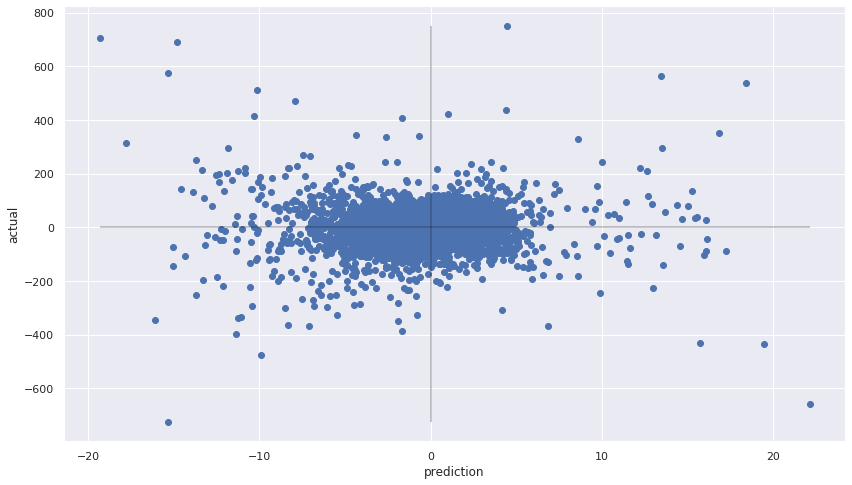

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
plt.scatter(res_df['prediction'], res_df['actual'])
plt.hlines(0, xmin=res_df['prediction'].min(), xmax=res_df['prediction'].max(), alpha=0.3)
plt.vlines(0, ymin=res_df['actual'].min(), ymax=res_df['actual'].max(), alpha=0.3)
plt.xlabel('prediction')
plt.ylabel('actual')
plt.show()

Or we can take average of data chunks and see if there are any general trend in predictions:

In [24]:
chunk_size = 2000
prev_i = None
res_df = res_df.sort_values('actual').reset_index(drop=True)
chunks_df = pd.DataFrame()
data_len = training_df.shape[0]
for i in range(0, data_len, chunk_size):
    if prev_i is None:
        prev_i = 0
        continue
    train_preds_chunk = res_df.loc[range(prev_i, i), 'prediction'].mean()
    train_labels_chunk = res_df.loc[range(prev_i, i), 'actual'].mean()
    chunks_df = chunks_df.append(pd.DataFrame({'prediction': [train_preds_chunk], 'actual': [train_labels_chunk]})).reset_index(drop=True)
    pct_ind = int((1 + i) * 50 / data_len)
    sys.stdout.write('\r')
    sys.stdout.write('Computing in progress: [{}{}] {}%'.format("=" * pct_ind, "-" * (50 - pct_ind), pct_ind * 100 / 50) + f' | from {prev_i} to {i}')
    prev_i = i

# Remainders
prev_i = i
i = data_len
train_preds = res_df.loc[range(prev_i, i), 'prediction'].mean()
train_labels = res_df.loc[range(prev_i, i), 'actual'].mean()
pct_ind = 50
sys.stdout.write('\r')
sys.stdout.write('Computing in progress: [{}{}] {}%'.format("=" * pct_ind, "-" * (50 - pct_ind), pct_ind * 100 / 50) + f' | from {prev_i} to {i - 1}')
res_df = res_df.append(pd.DataFrame({'prediction': [train_preds], 'actual': [train_labels]})).reset_index(drop=True)
print('\nFinished computing all predictions')

Computing in progress: [==================================================] 100.0% | from 312000 to 313193
Finished computing all predictions


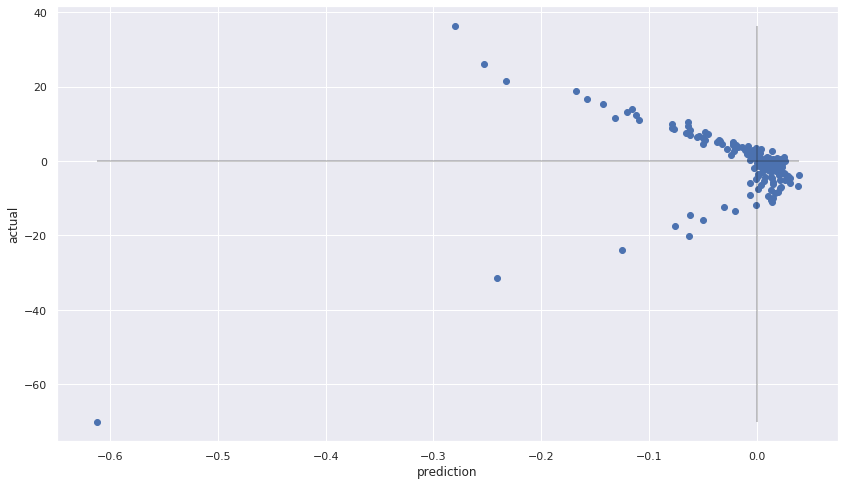

In [29]:
plt.figure(figsize=(14, 8))
plt.scatter(chunks_df['prediction'], chunks_df['actual'])
plt.hlines(0, xmin=chunks_df['prediction'].min(), xmax=chunks_df['prediction'].max(), alpha=0.3)
plt.vlines(0, ymin=chunks_df['actual'].min(), ymax=chunks_df['actual'].max(), alpha=0.3)
plt.xlabel('prediction')
plt.ylabel('actual')
plt.show()

The result is not very obvious even if we try to look only at the general trend ... We will need to think about how to improve the result in the next notebook.

But before that, let's delete the endpoint before going.

In [26]:
def delete_endpoint(target_predictor):
    try:
        boto3.client('sagemaker').delete_endpoint(EndpointName=target_predictor.endpoint)
        print('Deleted {}'.format(target_predictor.endpoint))
    except:
        print('Already deleted: {}'.format(target_predictor.endpoint))
    return

In [28]:
delete_endpoint(predictor)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Deleted sagemaker-pytorch-2021-01-12-08-59-52-575


In the next notebook, we will try to find other ways to improve the model and also try other algorithms.